In [1]:
library(IRkernel)
library(IRdisplay)
library(repr)
library(base64enc)

suppressPackageStartupMessages({
    library(xlsx)
    library(destiny)
    library(Biobase)
})

options(device = function(...) png('/dev/null', 7, 6, 'in', res = 120))
options(repr.plot.width = 7, repr.plot.height = 6)
options(jupyter.plot_mimetypes = c('application/pdf', 'image/png'))

setHook('on.rgl.close', function(...) {
    name <- tempfile()
    par3d(windowRect = c(0, 0, 1200,1200))
    Sys.sleep(1)
    
    rgl.snapshot(  filename = paste0(name, '.png'))
   #rgl.postscript(filename = paste0(name, '.pdf'), fmt='pdf')  # doesn’t work with spheres
    
    res <- getOption('repr.plot.res')
    
    publish_mimebundle(list(
        'image/png'       = base64encode(paste0(name, '.png'))
     #, 'application/pdf' = base64encode(paste0(name, '.pdf'))
    ), list(
        width  = res * getOption('repr.plot.width'),
        height = res * getOption('repr.plot.height')
    ))
}, 'replace')

Diffusion maps are spectral method for non-linear dimension reduction introduced by <cite data-cite=coifman_geometric_2005>Coifman et al. (2005)</cite>. Diffusion maps are based on a distance metric (diffusion distance) which is conceptually relevant to how differentiating cells follow noisy diffusion-like dynamics, moving from a pluripotent state towards more differentiated states.

The R package **destiny** implements the formulation of diffusion maps presented in <cite data-cite=haghverdi_diffusion_2015>Haghverdi et al. (2015)</cite> which is especially suited for analyzing single-cell gene expression data from time-course experiments. It implicitly arranges cells along their developmental path, with bifurcations where differentiation events occur.

In particular we follow <cite data-cite=haghverdi_diffusion_2015>Haghverdi et al. (2015)</cite> and present an implementation of diffusion maps in R that is less affected by sampling density heterogeneities and thus capable of identifying both abundant and rare cell populations. In addition, **destiny** implements complex noise models reflecting zero-inflation/censoring due to drop-out events in single-cell qPCR data and allows for missing values. Finally, we further improve on the implementation from <cite data-cite=haghverdi_diffusion_2015>Haghverdi et al. (2015)</cite>, and implement a nearest neighbour approximation capable of handling very large data sets of up to 300.000 cells.

For those familiar with R, and data preprocessing, we recommend the section [Plotting](#Plotting).

All code in this vignette is accessible via `edit(vignette('destiny'))`

Preprocessing of single qPCR data
================

As an example, we present in the following the preprocessing of data from <cite data-cite=guo_resolution_2010>Guo et al. (2010)</cite>. This dataset was produced by the Biomark RT-qPCR system and contains Ct values for 48 genes of 442 mouse embryonic stem cells at 7 different developmental time points, from the zygote to blastocyst.

Starting at the totipotent 1-cell stage, cells transition smoothly in the transcriptional landscape towards either the trophoectoderm lineage or the inner cell mass. Subsequently, cells transition from the inner cell mass either towards the endoderm or epiblast lineage. This smooth transition from one developmental state to another, including two bifurcation events, is reflected in the expression profiles of the cells and can be visualized using **destiny**.

Import
-----

Downloading the table S4 from the [publication website](http://www.sciencedirect.com/science/article/pii/S1534580710001103) will give you a spreadsheet “mmc4.xls”, from which the data can be loaded:

In [2]:
library(xlsx)
raw_ct <- read.xlsx('mmc4.xls', sheetName = 'Sheet1')

raw_ct[1:9, 1:9]  #preview of a few rows and columns

Cell,Actb,Ahcy,Aqp3,Atp12a,Bmp4,Cdx2,Creb312,Cebpa
1C 1,14.01,19.28,23.89,28,28,21.28,20.84,28.00
1C 2,13.68,18.56,28.00,28,28,23.43,20.93,28.00
1C 3,13.42,18.19,26.18,28,28,22.87,19.61,28.00
1C 4,13.69,18.59,28.00,28,28,23.28,20.72,28.00
1C 5,13.47,18.60,24.20,28,28,24.19,21.75,23.69
1C 6,12.86,17.37,25.53,28,28,21.87,21.27,28.00
1C 7,12.95,17.37,23.93,28,28,22.74,21.12,28.00
1C 8,12.77,18.40,23.68,28,28,24.14,19.80,28.00
1C 9,13.29,18.26,28.00,28,28,21.91,21.18,28.00


The value 28 is the assumed background expression of 28 cycle times.

In order to easily clean and normalize the data without mangling the annotations, we convert the `data.frame` into a Bioconductor `ExpressionSet` using the `as.ExpressionSet` function from the **destiny** package, and assign it to the name `ct`:

In [3]:
library(destiny)
library(Biobase)

ct <- as.ExpressionSet(raw_ct)
ct

ExpressionSet (storageMode: lockedEnvironment)
assayData: 48 features, 442 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: 1 2 ... 442 (442 total)
  varLabels: Cell
  varMetadata: labelDescription
featureData: none
experimentData: use 'experimentData(object)'
Annotation:  

The advantage of `ExpressionSet` over `data.frame` is that tasks like normalizing the expressions are both faster and do not accidentally destroy annotations by applying “normalization” to columns that are not expressions. The approach of handling a separate expression `matrix` and annotation `data.frame` requires you to be careful when adding or removing samples on both variables, while `ExpressionSet` does it internally for you.

The object internally stores an expression matrix of features × samples, retrievable using `exprs(ct)`, and an annotation `data.frame` of samples × annotations as `phenoData(ct)`. Annotations can be accessed directly via `ct$column` and `ct[['column']]`. Note that the expression matrix is transposed compared to the usual samples × features `data.frame`.

Data cleaning
----------

We remove all cells that have a value bigger than the background expression, indicating data points not available (`NA`). Also we remove cells from the 1 cell stage embryos, since they were treated systematically different (<cite data-cite=guo_resolution_2010>Guo et al., 2010</cite>).

For this, we add an annotation column containing the embryonic cell stage for each sample by extracting the number of cells from the “Cell” annotation column:

In [4]:
num_cells <- gsub('^(\\d+)C.*$', '\\1', ct$Cell)
ct$num_cells <- as.integer(num_cells)

We then use the new annotation column to create two filters:

In [5]:
# cells from 2+ cell embryos
have_duplications <- ct$num_cells > 1
# cells with values ≤ 28
normal_vals <- apply(exprs(ct), 2, function(sample) all(sample <= 28))

We can use the combination of both filters to exclude both non-divided cells and such containing Ct values higher than the baseline, and store the result as `cleaned.ct`:

In [6]:
cleaned_ct <- ct[, have_duplications & normal_vals]

Normalization
----------

Finally we follow <cite data-cite=guo_resolution_2010>Guo et al. (2010)</cite> and normalize each cell using the endogenous controls Actb and Gapdh by subtracting their average expression for each cell. Note that it is not clear how to normalise sc-qPCR data as the expression of housekeeping genes is also stochastic. Consequently, if such housekeeping normalisation is performed, it is crucial to take the mean of several genes.

In [7]:
housekeepers <- c('Actb', 'Gapdh')  # houskeeper gene names

normalizations <- colMeans(exprs(cleaned_ct)[housekeepers, ])

guo_norm <- cleaned_ct
exprs(guo_norm) <- exprs(guo_norm) - normalizations

The resulting `ExpressionSet` contains the normalized Ct values of all cells retained after cleaning.

Plotting
====

The data necessary to create a diffusion map with our package is a a cell×gene `matrix` or `data.frame`, or alternatively an `ExpressionSet` (which has a gene×cell `exprs` matrix). In order to create a `DiffusionMap` object, you just need to supply one of those formats as first parameter to the `DiffusionMap` function. In the case of a `data.frame`, each floating point column is interpreted as expression levels, and columns of different type (e.g. `factor`, `character` or `integer`) are assumed to be annotations and ignored. Note that single-cell RNA-seq count data should be transformed using a variance-stabilizing transformation (e.g. log or rlog); the Ct scale for qPCR data is logarithmic already (an increase in 1 Ct corresponds to a doubling of transcripts).

In order to create a diffusion map to plot, you have to call `DiffusionMap`, optionally with parameters. If the number of cells is small enough (< ~1000), you do not need to specify approximations like `k` (for k nearest neighbors).

If you started reading here, execute `data(guo.norm)` to load the dataset that was created in the previous section.

In [8]:
library(destiny)
#data(guo_norm)
dm <- DiffusionMap(guo_norm)

Simply calling `plot` on the resulting object `dif` will visualize the diffusion components:

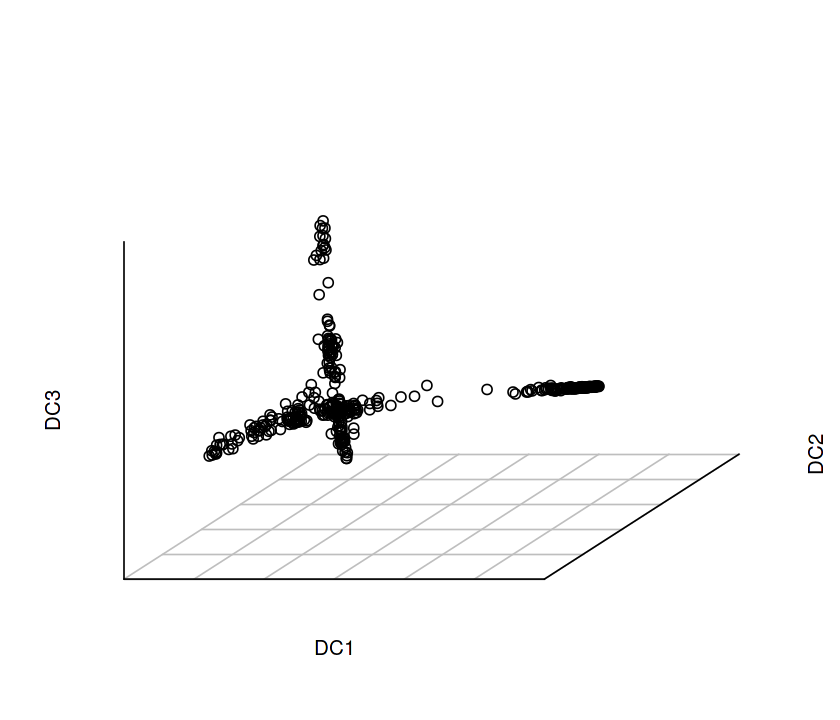

In [9]:
plot(dm)

The diffusion map nicely illustrates a branching during the first days of embryonic development.

The annotation column containing the cell stage can be used to annotate our diffusion map. Using the annotation as `col` parameter will automatically color the map using the current R color palette. Use `palette(colors)` to configure it globally or `plot(..., pal = colors)` for one plot.

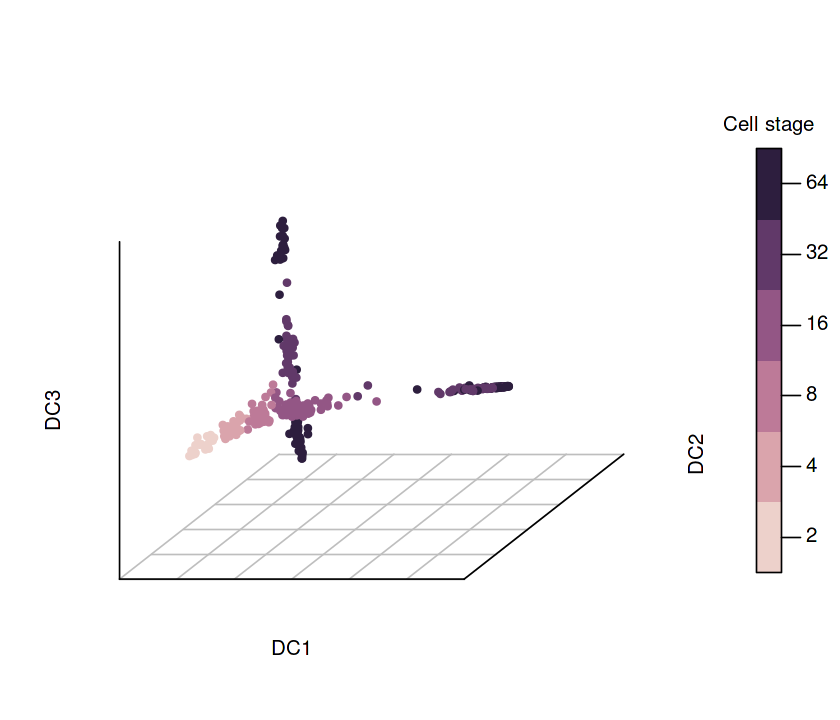

In [67]:
palette(cube_helix(6)) # configure color palette

plot(dm, pch = 20,         # pch for prettier points
     col_by = 'num_cells', # or “col” to use a vector or a single color
     legend_main = 'Cell stage')

Three branches appear in the map, with a bifurcation occurring the 16 cell stage and the 32 cell stage. The diffusion map is able to arrange cells according to their expression profile: Cells that divided the most and the least appear at the tips of the different branches.

In order to display a 2D plot we supply a vector containing two diffusion component numbers (here 1 & 2) as second argument.

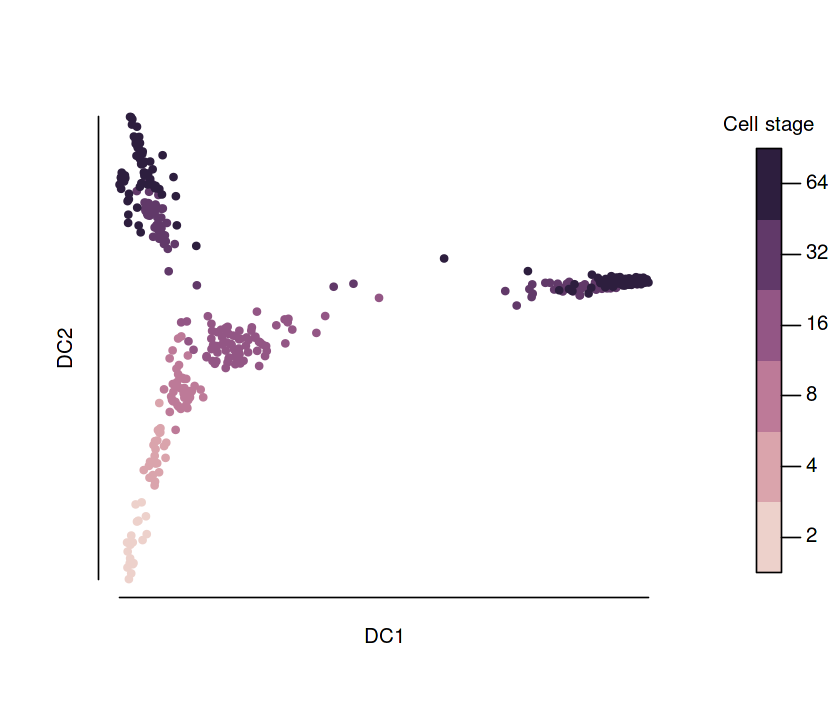

In [36]:
plot(dm, 1:2, pch = 20, col_by = 'num_cells',
     legend_main = 'Cell stage')

Alternative visualizations
-------------

Diffusion maps consist of eigenvectors called Diffusion Components (DCs) and corresponding eigenvalues. Per default, the first 20 are returned.

You are also able to use packages for interative plots like `rgl` in a similar fashion, by directly subsetting the DCs using `eigenvectors(dif)`:

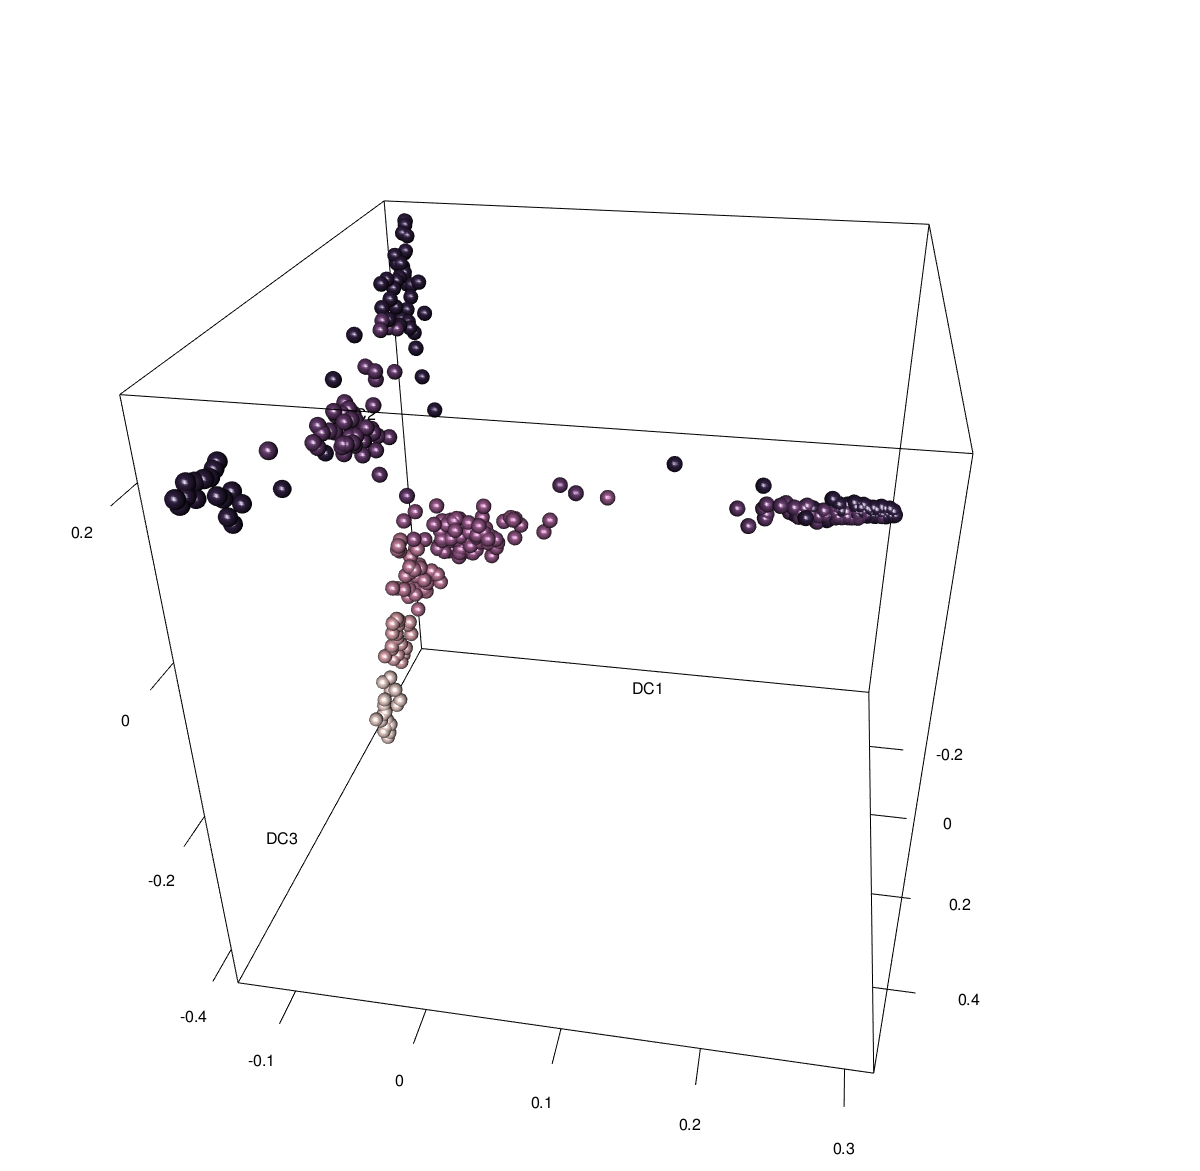

In [37]:
library(rgl)
plot3d(eigenvectors(dm)[, 1:3],
       col = log2(guo_norm$num_cells),
       type = 's', radius = .01)
view3d(theta = 10, phi = 30, zoom = .8)
# now use your mouse to rotate the plot in the window
rgl.close()

For the popular `ggplot2` package, there is built in support in the form of a `fortify.DiffusionMap` method, which allows to use DiffusionMap objects as `data` parameter in the `ggplot` and `qplot` functions:

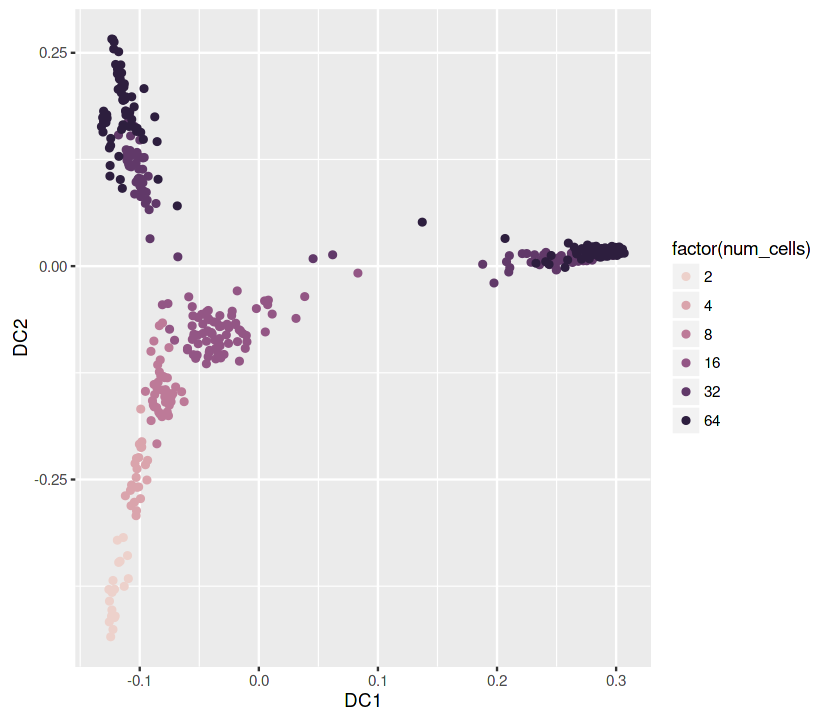

In [39]:
library(ggplot2)
qplot(DC1, DC2, data = dm, colour = factor(num_cells)) +
    scale_color_cube_helix()
# or alternatively:
#ggplot(dif, aes(DC1, DC2, colour = factor(num.cells))) + ...

As aesthetics, all diffusion components, gene expressions, and annotations are available. If you plan to make many plots, create a `data.frame` first by using `as.data.frame(dif)` or `fortify(dif)`, assign it to a variable name, and use it for plotting.

Parameter selection
=========

Two important parameters to `DiffusionMap`, [`dims`](#Dimensions-dims) and [`sigma`](#Gaussian-kernel-width-sigma), crucially determine the diffusion map approximation and are explained in detail in the following section.

[Other parameters](#Other parameters) are explained at the end of this section.

Dimensions `dims`
-------------

Diffusion maps consist of the eigenvectors (which we refer to as diffusion components) and corresponding eigenvalues of the diffusion distance matrix. The latter indicate the diffusion components’ importance, i.e. how well the eigenvectors approximate the data. The eigenvectors are decreasingly meaningful.

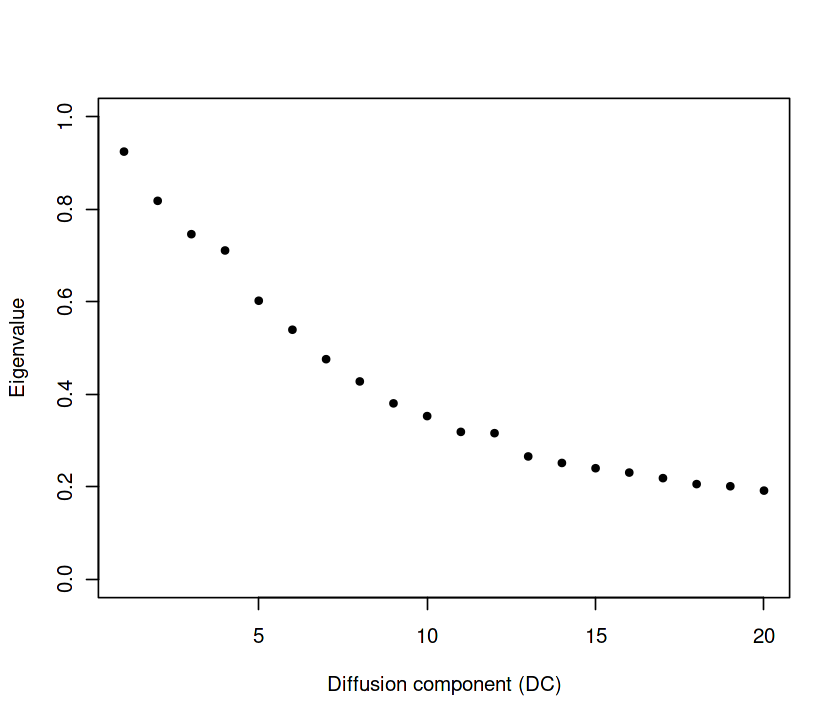

In [40]:
plot(eigenvalues(dm), ylim = 0:1, pch = 20,
     xlab = 'Diffusion component (DC)', ylab = 'Eigenvalue')

The later DCs often become noisy and less useful:

In [41]:
oh <- options('repr.plot.height')
options(repr.plot.height = 3)

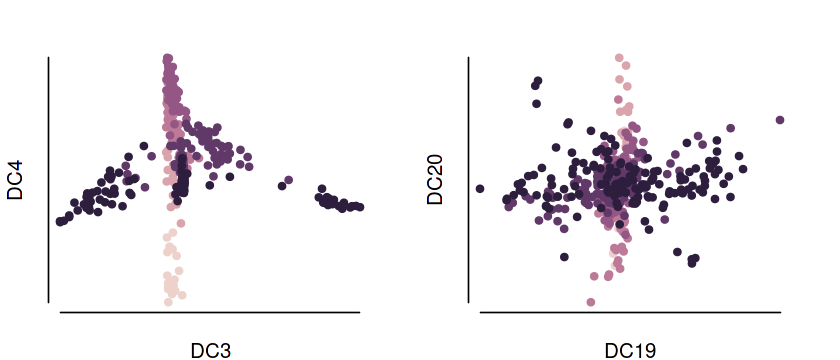

In [42]:
par(mfrow = c(1, 2), mar = c(2,2,2,2))

plot(dm, 3:4,   pch = 20, col_by = 'num_cells', draw_legend = FALSE)
plot(dm, 19:20, pch = 20, col_by = 'num_cells', draw_legend = FALSE)

In [43]:
options(oh)

Gaussian kernel width `sigma`
-----------------------

The other important parameter for `DiffusionMap` is the Gaussian kernel width `sigma` ($\sigma$) that determines the transition probability between data points. The default call of **destiny** – `DiffusionMap(data)` – automatically estimates sigma using a heuristic. It is also possible to specify this parameter manually to tweak the result. The eigenvector plot explained above will show a continuous decline instead of sharp drops if either the dataset is too big or the `sigma` is chosen too small.

The sigma estimation algorithm is explained in detail in <cite data-cite=haghverdi_diffusion_2015>Haghverdi et al. (2015)</cite>. In brief, it works by finding a maximum in the slope of the log-log plot of local density versus `sigma`.

### Using find.sigmas

An efficient variant of that procedure is provided by `find.sigma`. This function determines the optimal sigma for a subset of the given data and provides the default sigma for a `DiffusionMap` call. Due to a different starting point, the resulting sigma is different from above:

In [44]:
sigmas <- find_sigmas(guo_norm, verbose = FALSE)
optimal_sigma(sigmas)

[1] 10.8946

The resulting diffusion map’s approximation depends on the chosen sigma. Note that the sigma estimation heuristic only finds local optima and even the global optimum of the heuristic might not be ideal for your data.

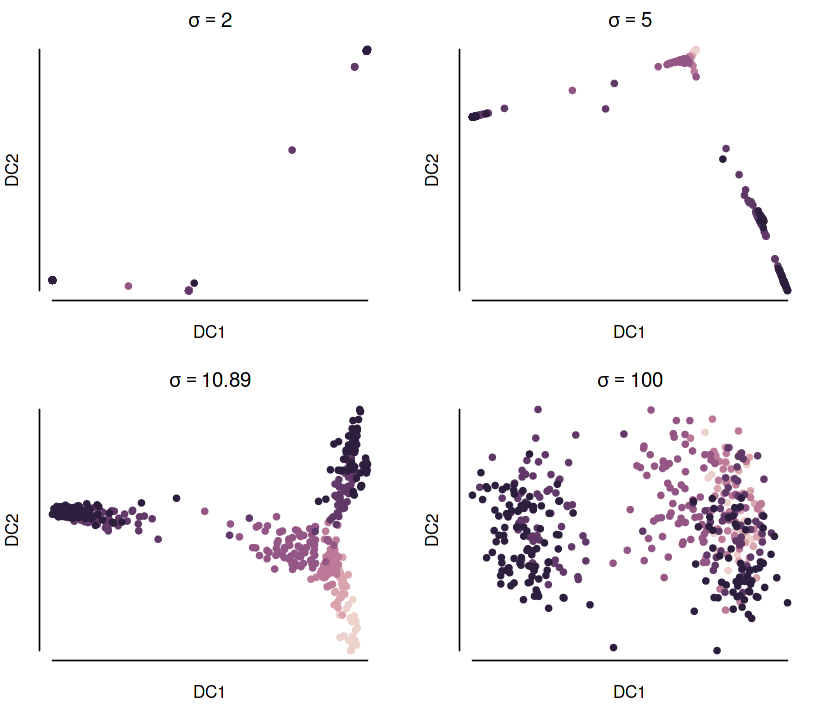

In [45]:
par(pch = 20, mfrow = c(2, 2), mar = c(3,2,2,2))

for (sigma in c(2, 5, optimal_sigma(sigmas), 100))
    plot(DiffusionMap(guo_norm, sigma), 1:2,
         main = substitute(sigma == s, list(s = round(sigma,2))),
         col_by = 'num_cells', draw_legend = FALSE)

Other parameters
-------------

If the automatic exclusion of categorical and integral features for data frames is not enough, you can also supply a vector of variable names or indices to use with the `vars` parameter. If you find that calculation time or used memory is too large, the parameter `k` allows you to decrease the quality/runtime+memory ratio by limiting the number of transitions calculated and stored. It is typically not needed if you have less than few thousand cells. The `n.eigs` parameter specifies the number of diffusion components returned.

For more information, consult `help(DiffusionMap)`.

Missing and uncertain values
=============

**destiny** is particularly well suited for gene expression data due to its ability to cope with missing and uncertain data.

Censored values
------------

Platforms such as RT-qPCR cannot detect expression values below a certain threshold. To cope with this, **destiny** allows to censor specific values. In the case of <cite data-cite=guo_resolution_2010>Guo et al. (2010)</cite>, only up to 28 qPCR cycles were counted. All transcripts that would need more than 28 cycles are grouped together under this value. This is illustrated by gene Aqp3:

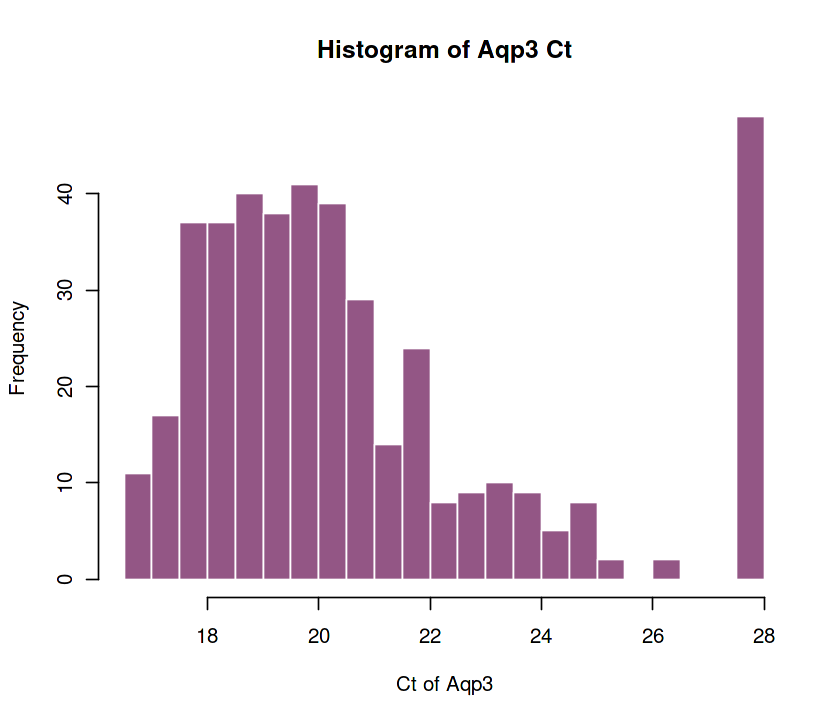

In [49]:
hist(exprs(cleaned_ct)['Aqp3', ], breaks = 20,
     xlab = 'Ct of Aqp3', main = 'Histogram of Aqp3 Ct',
     col = palette()[[4]], border = 'white')

For our censoring noise model we need to identify the limit of detection (LoD). While most researchers use a global LoD of 28, reflecting the overall sensitivity of the qPCR machine, different strategies to quantitatively establish this gene-dependent LoD exist. For example, dilution series of bulk data can be used to establish an LoD such that a qPCR reaction will be detected with a specified probability if the Ct value is below the LoD. Here, we use such dilution series provided by Guo et al. and first determine a gene-wise LoD as the largest Ct value smaller than 28. We then follow the manual [Application Guidance: Single-Cell Data Analysis](https://www.bioke.com/Product%20Support/Manuals%20%26%20Downloads/?webshop_supplier=15&webshop_downloadtype=10&webshop_application=199&q=) of the popular Biomarks system and determine a global LoD as the median over the gene-wise LoDs. We use the dilution series from table S7 (`mmc6.xls`). If you have problems with the speed of `read.xlsx`, consider storing your data in tab separated value format and using `read.delim` or `read.ExpressionSet`.

In [50]:
dilutions <- read.xlsx('mmc6.xls', 1L)
dilutions$Cell <- NULL #remove annotation column

lods <- apply(dilutions, 2, function(col) col[[max(which(col != 28))]])
lod <- ceiling(median(lods))
lod

[1] 25

This LoD of 25 and the maximum number of cycles the platform can perform (40), defines the uncertainty range that denotes the possible range of censored values in the censoring model. Using the mean of the normalization vector, we can adjust the uncertainty range and censoring value to be more similar to the other values in order to improve distance measures between data points:

In [51]:
lod_norm <- ceiling(median(lods) - mean(normalizations))
max_cycles_norm <- ceiling(40 - mean(normalizations))

list(lod_norm = lod_norm, max_cycles_norm = max_cycles_norm)

$lod_norm
[1] 10

$max_cycles_norm
[1] 25

We then also need to set the normalized values that should be censored – namely all data points were no expression was detected after the LoD – to this special value, because the values at the cycle threshold were changed due to normalization.

In [52]:
guo <- guo_norm
exprs(guo)[exprs(cleaned_ct) >= 28] <- lod_norm

This version of the dataset is avaliable as `data(guo)` from the **destiny** package.

Now we call the the `DiffusionMap` function using the censoring model:

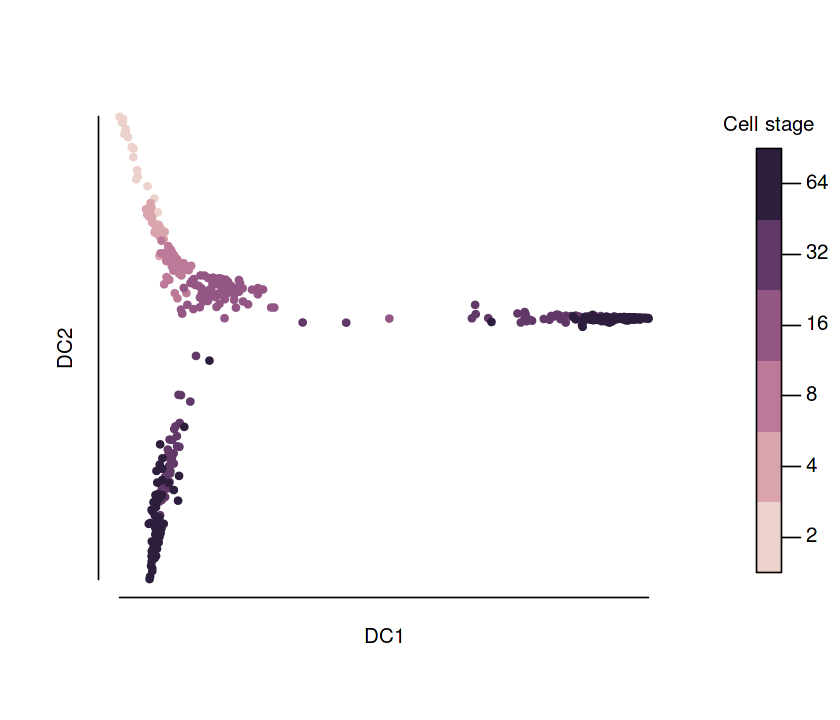

In [53]:
thresh_dm <- DiffusionMap(guo,
                          censor_val = lod_norm,
                          censor_range = c(lod_norm, max_cycles_norm),
                          verbose = FALSE)

plot(thresh_dm, 1:2, col_by = 'num_cells', pch = 20,
     legend_main = 'Cell stage')

Compared to the diffusion map created without censoring model, this map looks more homogeneous since it contains more data points.

Missing values
-----------

Gene expression experiments may fail to produce some data points, conventionally denoted as “not available” (`NA`). By calling `DiffusionMap(..., missings = c(total.minimum, total.maximum))`, you can specify the parameters for the missing value model.

As in the data from <cite data-cite=guo_resolution_2010>Guo et al. (2010)</cite> no missing values occurred, we illustrate the capacity of **destiny** to handle missing values by artificially treating ct values of 999 (i.&thinsp;e. data points were no expression was detected after 40 cycles) as missing. This is purely for illustrative purposes and in practice these values should be treated as censored as illustrated in the previous section.

In [54]:
# remove rows with divisionless cells
ct_w_missing <- ct[, ct$num_cells > 1L]
# and replace values larger than the baseline
exprs(ct_w_missing)[exprs(ct_w_missing) > 28] <- NA

We then perform normalization on this version of the data:

In [55]:
housekeep <- colMeans(exprs(ct_w_missing)[housekeepers, ],
                      na.rm = TRUE)

w_missing <- ct_w_missing
exprs(w_missing) <- exprs(w_missing) - housekeep

exprs(w_missing)[is.na(exprs(ct_w_missing))] <- lod_norm

Finally, we create a diffusion map with both missing value model and the censoring model from before:

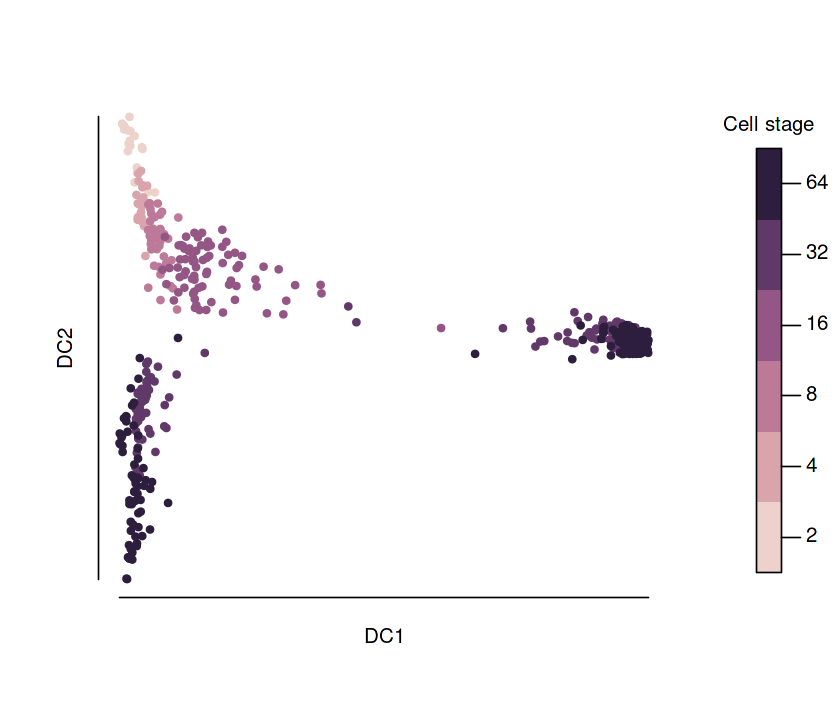

In [56]:
dif_w_missing <- DiffusionMap(w_missing,
                              censor_val = lod_norm,
                              censor_range = c(lod_norm,
                                               max_cycles_norm),
                              missing_range = c(1, 40),
                              verbose = FALSE)

plot(dif_w_missing, 1:2, col_by = 'num_cells', pch = 20,
     legend_main = 'Cell stage')

This result looks very similar to our previous diffusion map since only six additional data points have been added. However if your platform creates more missing values, including missing values will be more useful.

Prediction
=====

In order to project cells into an existing diffusion map, for example to compare two experiments measured by the same platform or to add new data to an existing map, we implemented `dm.predict`. It calculates the transition probabilities between datapoints in old and new data and projects cells into the diffusion map using the existing diffusion components.

As an example we assume that we created a diffusion map from one experiment on 64 cell stage embryos:

In [57]:
ct64 <- guo[, guo$num_cells == 64]

dm64 <- DiffusionMap(ct64)

Let us compare the expressions from the 32 cell state embryos to the existing map. We use `dm.predict` to create the diffusion components for the new cells using the existing diffusion components from the old data: 

In [58]:
ct32 <- guo[, guo$num_cells == 32]
pred32 <- dm_predict(dm64, ct32)

By providing the `more` and `col.more` parameters of the `plot` function, we show the first two DCs for both old and new data: 

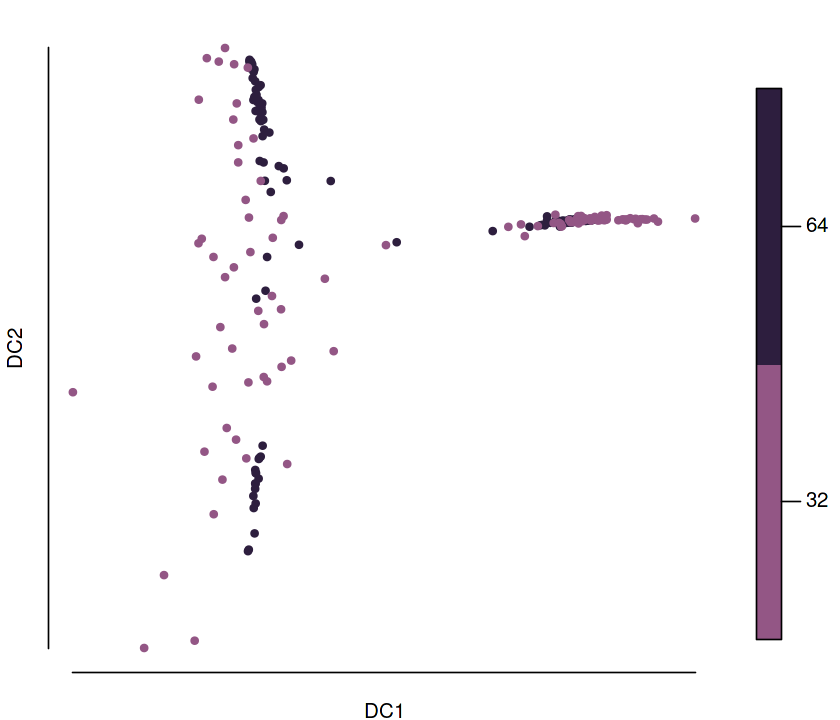

In [69]:
par(mar = c(2,2,1,5), pch = 20)
plot(dm64,    1:2,     col     = palette()[[6]],
     new_dcs = pred32, col_new = palette()[[4]])
colorlegend(c(32L, 64L), palette()[c(4,6)])

Clearly, the 32 and 64 cell state embryos occupy similar regions in the map, while the cells from the 64 cell state are developed further.

Troubleshooting
=======

There are several properties of data that can yield subpar results. This section explains a few strategies of dealing with them:

**`read.xlsx` is slow**: Using `read.xlsx2` and manually converting the text columns into numbers aftwerwards could be a solution, but using tab separated values (TSV) or comma separated values (CSV) is more portable and robust than Microsoft Excel.

**Preprocessing**: if there is a strong dependency of the variance on the mean in your data (as for scRNA-Seq count data),  use a variance stabilizing transformation such as the square root or a (regularized) logarithm before running **destiny**.

**Outliers**: If a Diffusion Component strongly separates some outliers from the remaining cells such that there is a much greater distance between them than within the rest of the cells (i.&thinsp;e. almost two discrete values), consider removing those outliers and recalculating the map, or simply select different Diffusion Components. It may also a be a good idea to check whether the outliers are also present in a PCA plot to make sure they are not biologically relevant.

**Large datasets**: If memory is not sufficient and no machine with more RAM is available, the `k` parameter could be decreased. In addition (particularly for >500,000 cells), you can also downsample the data (possibly in a density dependent fashion).

**“Large-p-small-n” data**: E.g. for scRNA-Seq, it is may be necessary to first perform a Principal Component Analysis (PCA) on the data (e.g. using `prcomp` or `princomp`) and to calculate the Diffusion Components from the Principal Components (typically using the top 50 components yields good results).